# Activation Patching

In [1]:
import torch, transformer_lens, itertools
from functools import partial

from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)

from tqdm import tqdm
from measureLM import helpers, measuring, synth_data

## Data and Model

In [63]:
model_name = "gpt2-medium"
model = measuring.load_model(model_name=model_name, device="mps")

Using pad_token, but it is not set yet.


RuntimeError: MPS backend out of memory (MPS allocated: 50.06 GB, other allocations: 31.39 GB, max allowed: 81.60 GB). Tried to allocate 196.32 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [ ]:
def construct_bias_context_pairs(df, pair_type="bias"):
    
    prompt = "The relationship between {ent1} and {ent2} is"
    pos_prefix = "{ent1} loves {ent2}."
    neg_prefix = "{ent1} hates {ent2}."
    
    ent1_ent2 = list(zip(df["ent1"].to_list(), df["ent2"].to_list()))
    
    if pair_type=="bias":
        ent1_ent2_pairs = []
        entPair1_entPair2 = list(itertools.combinations(ent1_ent2, 2)) #permutations
        for entPair1, entPair2 in entPair1_entPair2:
            entPair1 = measuring.form_prompt(prompt,{"ent1":entPair1[0],"ent2":entPair1[1]})
            entPair2 = measuring.form_prompt(prompt,{"ent1":entPair2[0],"ent2":entPair2[1]})
            ent1_ent2_pairs.append((entPair1, entPair2))
        
    elif pair_type=="context":
        ent1_ent2_pairs = []
        for ent1, ent2 in ent1_ent2:
            no_context_prompt = measuring.form_prompt(f"{prompt}", {"ent1": ent1, "ent2": ent2})
            pos_context = measuring.form_prompt(f"{pos_prefix} {prompt}", {"ent1": ent1, "ent2": ent2})
            neg_context = measuring.form_prompt(f"{neg_prefix} {prompt}", {"ent1": ent1, "ent2": ent2})

            ent1_ent2_pairs.append((no_context_prompt, pos_context))
            ent1_ent2_pairs.append((no_context_prompt, neg_context))
        
    print(f"pair_type: {pair_type} --> {len(ent1_ent2_pairs)} data points")
    return ent1_ent2_pairs

scales = ["positive", "negative"]
scale_idx = measuring.get_logit_indices(scales, model)

df = synth_data.load_synth_data(n=5, seed=10)
prompt_pairs = construct_bias_context_pairs(df, pair_type="context")
prompt_pairs

## Activation Patching

In [62]:
def patch_hook_point(patch_activs, hook: HookPoint, new_activs, hook_layer_name, extract_tok_idx=-1, insert_tok_idx=None):
    #print(f'patching {hook.name} <-- {hook_layer_name}')
    if extract_tok_idx is None or extract_tok_idx == -1:
        extract_tok_idx = (0, -1)
    if insert_tok_idx is None:
        insert_tok_idx = extract_tok_idx
    new_activs_hook = new_activs[hook_layer_name]
    vector_direction.append(torch.stack([new_activs_hook[extract_tok_idx], patch_activs[insert_tok_idx]]))
    patch_activs[insert_tok_idx] = new_activs_hook[extract_tok_idx]


def patch_activs(model, old_logits, new_logits, new_activs, old_prompt, logit_idx):
    
    n_layers = model.cfg.n_layers
    activ_d = model.cfg.d_model
    hook_names = ["attn_out", "mlp_out"]
    
    effect_strength = torch.zeros(n_layers,len(hook_names), device=model.cfg.device)
    global vector_direction
    vector_direction = [] 

    for layer in (range(n_layers)):
        for hook_i, hook_name in enumerate(hook_names): 

            hook_layer_name = transformer_lens.utils.get_act_name(hook_name, layer)
            patch_layers_fn = [(hook_layer_name, partial(patch_hook_point, new_activs=new_activs, hook_layer_name=hook_layer_name))]
            patched_logits = model.run_with_hooks(old_prompt,fwd_hooks=patch_layers_fn,reset_hooks_end=True)
            
            ## get measurement change
            patched_logits = measuring.select_logits(patched_logits,logit_idx,norm=False)
            patched_logit_diff = (patched_logits[...,0]-patched_logits[...,1])
            
            ## store effect strength
            old_logit_diff = (old_logits[...,0]-old_logits[...,1])
            new_logit_diff = (new_logits[...,0]-new_logits[...,1])
            effect_strength[layer, hook_i] = torch.abs((patched_logit_diff-old_logit_diff)) / torch.abs((new_logit_diff-old_logit_diff))
            #effect_strength[layer, hook_i] = torch.abs(patched_logits[...,0]-old_logits[...,0])
            
    vector_direction = torch.stack(vector_direction) 
    vector_direction = torch.movedim(vector_direction,0,1)
    vector_direction = vector_direction.view(2,model.cfg.n_layers,-1,model.cfg.d_model)
    return effect_strength.detach(), vector_direction.detach()
        

new_prompt = ["Harry Potter loves Ronald Weasley. The relationship between Harry Potter and Ronald Weasley is"]
old_prompt = ["The relationship between Harry Potter and Ronald Weasley is"]
#old_prompt = ["The relationship between Jack and Mary is"]

#new_prompt = ["Democrats like Republicans. The relationship between Democrats and Republicans is"]
new_prompt = ["The relationship between Democrats and Republicans is"]
old_prompt = ["The relationship between Harry and Ron is"]

old_logits, old_activs = measuring.prompt_with_cache(model,old_prompt,logit_idx=scale_idx,norm=False)
new_logits, new_activs = measuring.prompt_with_cache(model,new_prompt,logit_idx=scale_idx,norm=False)

vector_scale, vector_dir = patch_activs(model, old_logits, new_logits, new_activs, old_prompt, scale_idx)
plot_heatmap(vector_scale.cpu().numpy(), title='Patching Effect', cmap="binary")

RuntimeError: MPS backend out of memory (MPS allocated: 49.87 GB, other allocations: 31.74 GB, max allowed: 81.60 GB). Tried to allocate 50.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [ ]:
def run_patching_loop(model, prompt_pairs, scale_idx):
    
    all_vector_scale, all_vector_dir = [],[]    
    for (prompt_1, prompt_2) in tqdm(prompt_pairs, position=0): 
        
        old_logits, old_activs = measuring.prompt_with_cache(model,prompt_1,logit_idx=scale_idx)
        new_logits, new_activs = measuring.prompt_with_cache(model,prompt_2,logit_idx=scale_idx)
        vector_scale, vector_dir = patch_activs(model, old_logits, new_logits, new_activs, prompt_1, scale_idx)        
        
        all_vector_scale.append(vector_scale)
        all_vector_dir.append(vector_dir)

    vector_scale = torch.stack(all_vector_scale).detach() ## shape: prompt, layers, att vs mlp
    vector_scale = vector_scale.mean(0)
    vector_dir = torch.stack(all_vector_dir).detach() ## shape: prompt, new vs old, layers, att vs mlp, emb dim 
    return vector_scale, vector_dir
        
vector_scale, vector_dir = run_patching_loop(model, prompt_pairs, scale_idx)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


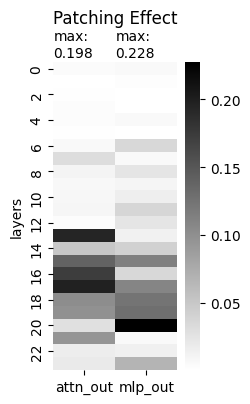

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np


import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np


def plot_heatmap(array, title='', xticklabels=["attn_out", "mlp_out"], cmap="binary"):
    titlefont, labelsize=12, 10
    fig, ax = plt.subplots(1, 1, figsize=(2, 4), gridspec_kw={'hspace': 0.4})
    ax = sns.heatmap(array, cmap=mpl.colormaps[cmap], xticklabels=xticklabels, square=False)
    ax.set_title(title, fontsize=titlefont, color="black", loc='center',  y=1.1)
    ax.set_ylabel('layers', fontsize=labelsize)
    
    mean_effect = list(map(lambda x: "%.3f" % x, list(array.max(0))))
    for i, x_tick_label in enumerate(ax.get_xticklabels()):
        ax.text(x_tick_label.get_position()[0]-0.5, -0.2, f"max:\n{mean_effect[i]}", fontsize=labelsize, color="black", verticalalignment='bottom')
    plt.show()
    
plot_heatmap(vector_scale.cpu().numpy(), title='Patching Effect', cmap="binary")

torch.Size([2, 24, 2, 1024])
torch.Size([2, 1024])


ValueError: 'c' argument has 2048 elements, which is inconsistent with 'x' and 'y' with size 2.

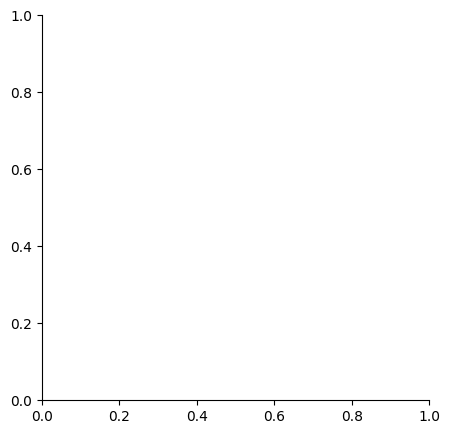

In [64]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.decomposition import PCA

def dim_reduction(embs, reduction="pca"):
    
    x = embs.view(-1, embs.shape[-1]).cpu().detach().numpy()
    
    y_len = int((embs.shape[0] * embs.shape[1])/2)
    y = ([0] * y_len + [1] * y_len)
    colormap = np.array(['g', 'r'])
    y = colormap[y]
    
    if reduction == "pca":
        pca = PCA(n_components=2)
        x_2D = pca.fit_transform(x)
        
    fig, (ax) = plt.subplots(1, figsize=(5, 5), gridspec_kw={'hspace': 0.40})
    ax.scatter(x_2D[:, 0], x_2D[:, 1], c=y)
    plt.show()
    
print(vector_dir.shape)
#dim_reduction(vector_dir.mean(0)[...,0,:].cpu())
a = vector_dir[...,0,:].mean(-2)
print(a.shape)
dim_reduction(a)